In [57]:
# Load NMNIST dataset
import tonic

dataset = tonic.datasets.NMNIST(save_to="../tutorials/data", train=False)

Frames shape: (100, 2, 34, 34)
Label: 0


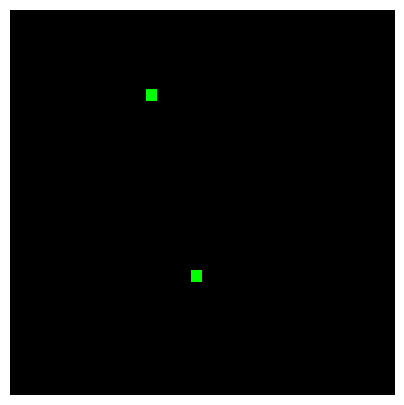

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for 

In [58]:
# Transform: Downsample, ToFrame, Animation
import tonic.transforms as transforms
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np

sensor_size = tonic.datasets.NMNIST.sensor_size
trans = transforms.Compose([
    transforms.ToFrame(sensor_size=(34,34,2), n_time_bins=100),
])

events, labels = dataset[9]
frames = trans(events)
print(f"Frames shape: {frames.shape}")
print(f"Label: {labels}")

# Animation erstellen und anzeigen
ani = tonic.utils.plot_animation(frames)
HTML(ani.to_jshtml())


In [59]:
# Flexible Flatten-Funktion für beliebige Frame-Shapes
from sklearn.manifold import Isomap

def analyze_frames_shape(frames):
    """
    Analysiert die Frame-Shape und gibt Informationen aus
    """
    print(f"Original frames shape: {frames.shape}")
    
    if len(frames.shape) == 4:  # (time_bins, channels, height, width)
        n_time_bins, n_channels, height, width = frames.shape
        features_per_timebin = n_channels * height * width
        total_features = n_time_bins * features_per_timebin
        
        print(f"Zeitbins: {n_time_bins}")
        print(f"Kanäle: {n_channels}")
        print(f"Spatiale Auflösung: {height}x{width}")
        print(f"Features pro Zeitbin: {features_per_timebin}")
        print(f"Gesamt Features: {total_features}")
        
        return n_time_bins, features_per_timebin, total_features
    else:
        print(f"Unerwartete Frame-Shape: {frames.shape}")
        return None, None, None

def flatten_frames_flexible(frames, flatten_mode='timebin'):
    """
    Flexible Flatten-Funktion für verschiedene Modi
    """
    n_time_bins, features_per_timebin, total_features = analyze_frames_shape(frames)
    
    if flatten_mode == 'timebin':
        # Jeder Zeitbin wird zu einem Feature-Vektor
        flattened = frames.reshape(frames.shape[0], -1)
        print(f"Flattened (timebin mode): {flattened.shape}")
        return flattened
    elif flatten_mode == 'complete':
        # Komplett flatten (ein großer Vektor pro Sample)
        flattened = frames.flatten().reshape(1, -1)
        print(f"Flattened (complete mode): {flattened.shape}")
        return flattened
    elif flatten_mode == 'spatial':
        # Flatten nur räumliche Dimensionen
        flattened = frames.reshape(frames.shape[0], frames.shape[1], -1)
        print(f"Flattened (spatial mode): {flattened.shape}")
        return flattened
    else:
        raise ValueError(f"Unbekannter flatten_mode: {flatten_mode}")

# Test mit aktuellen Frames
print("🔍 Frame-Analyse:")
n_time_bins, features_per_timebin, total_features = analyze_frames_shape(frames)

print("\n📊 Flatten-Tests:")
flattened_timebin = flatten_frames_flexible(frames, 'timebin')
flattened_complete = flatten_frames_flexible(frames, 'complete')


🔍 Frame-Analyse:
Original frames shape: (100, 2, 34, 34)
Zeitbins: 100
Kanäle: 2
Spatiale Auflösung: 34x34
Features pro Zeitbin: 2312
Gesamt Features: 231200

📊 Flatten-Tests:
Original frames shape: (100, 2, 34, 34)
Zeitbins: 100
Kanäle: 2
Spatiale Auflösung: 34x34
Features pro Zeitbin: 2312
Gesamt Features: 231200
Flattened (timebin mode): (100, 2312)
Original frames shape: (100, 2, 34, 34)
Zeitbins: 100
Kanäle: 2
Spatiale Auflösung: 34x34
Features pro Zeitbin: 2312
Gesamt Features: 231200
Flattened (complete mode): (1, 231200)


In [60]:
# Flexible Isomap-Pipeline für beliebige Konfigurationen
def create_flexible_isomap_pipeline(n_samples=50, flatten_mode='complete', n_components=2, n_neighbors=10):
    """
    Flexible Pipeline die automatisch mit verschiedenen Transform-Konfigurationen funktioniert
    """
    print(f"🚀 Starte flexible Isomap-Pipeline:")
    print(f"   Samples: {n_samples}")
    print(f"   Flatten-Mode: {flatten_mode}")
    print(f"   Components: {n_components}")
    print(f"   Neighbors: {n_neighbors}")
    
    all_flattened = []
    sample_info = []
    
    for i in range(n_samples):
        events, label = dataset[i]
        sample_frames = trans(events)
        
        # Analysiere die Frame-Shape des ersten Samples
        if i == 0:
            print(f"\n📊 Erste Sample-Analyse:")
            n_time_bins, features_per_timebin, total_features = analyze_frames_shape(sample_frames)
        
        # Flatten basierend auf gewähltem Modus
        if flatten_mode == 'complete':
            # Komplett flatten (ein Vektor pro Sample)
            flattened_sample = sample_frames.flatten()
        elif flatten_mode == 'timebin':
            # Jeder Zeitbin als separater Vektor
            flattened_sample = sample_frames.reshape(sample_frames.shape[0], -1)
            flattened_sample = flattened_sample.flatten()  # Für Isomap flatten
        elif flatten_mode == 'first_timebin':
            # Nur erster Zeitbin
            flattened_sample = sample_frames[0].flatten()
        else:
            raise ValueError(f"Unbekannter flatten_mode: {flatten_mode}")
        
        all_flattened.append(flattened_sample)
        sample_info.append((i, label))
    
    # Konvertiere zu numpy array für Isomap
    X = np.array(all_flattened)
    print(f"\n📈 Data matrix für Isomap: {X.shape}")
    
    # Robuste Parameter-Anpassung
    max_neighbors = min(n_neighbors, X.shape[0] - 1)
    max_components = min(n_components, X.shape[0] - 1)
    
    print(f"🔧 Angepasste Parameter: n_neighbors={max_neighbors}, n_components={max_components}")
    
    # Isomap anwenden
    try:
        isomap = Isomap(n_components=max_components, n_neighbors=max_neighbors)
        X_isomap = isomap.fit_transform(X)
        print(f"✅ Isomap result: {X_isomap.shape}")
        return X_isomap, sample_info, isomap
    except Exception as e:
        print(f"❌ Fehler bei Isomap: {e}")
        print("🔄 Verwende PCA als Fallback...")
        from sklearn.decomposition import PCA
        pca = PCA(n_components=max_components)
        X_pca = pca.fit_transform(X)
        print(f"✅ PCA result: {X_pca.shape}")
        return X_pca, sample_info, pca

# Test mit verschiedenen Modi
print("🧪 Test 1: Complete Flatten Mode")
X_result1, info1, model1 = create_flexible_isomap_pipeline(n_samples=20, flatten_mode='complete', n_components=3, n_neighbors=10)

print("\n🧪 Test 2: First Timebin Mode")
X_result2, info2, model2 = create_flexible_isomap_pipeline(n_samples=20, flatten_mode='first_timebin', n_components=3, n_neighbors=10)


🧪 Test 1: Complete Flatten Mode
🚀 Starte flexible Isomap-Pipeline:
   Samples: 20
   Flatten-Mode: complete
   Components: 3
   Neighbors: 10

📊 Erste Sample-Analyse:
Original frames shape: (100, 2, 34, 34)
Zeitbins: 100
Kanäle: 2
Spatiale Auflösung: 34x34
Features pro Zeitbin: 2312
Gesamt Features: 231200

📈 Data matrix für Isomap: (20, 231200)
🔧 Angepasste Parameter: n_neighbors=10, n_components=3
✅ Isomap result: (20, 3)

🧪 Test 2: First Timebin Mode
🚀 Starte flexible Isomap-Pipeline:
   Samples: 20
   Flatten-Mode: first_timebin
   Components: 3
   Neighbors: 10

📊 Erste Sample-Analyse:
Original frames shape: (100, 2, 34, 34)
Zeitbins: 100
Kanäle: 2
Spatiale Auflösung: 34x34
Features pro Zeitbin: 2312
Gesamt Features: 231200

📈 Data matrix für Isomap: (20, 2312)
🔧 Angepasste Parameter: n_neighbors=10, n_components=3
✅ Isomap result: (20, 3)


In [61]:
# Flexible 3D Visualisierung für beliebige Isomap-Ergebnisse
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def create_flexible_3d_plot(X_result, sample_info, title="3D Manifold", n_components=3):
    """
    Erstellt eine flexible 3D-Visualisierung basierend auf den Isomap-Ergebnissen
    """
    print(f"🎨 Erstelle 3D-Plot: {X_result.shape}")
    
    # Extrahiere Labels
    labels_for_plot = [info[1] for info in sample_info]
    
    # Bestimme die Anzahl der verfügbaren Komponenten
    actual_components = min(n_components, X_result.shape[1])
    print(f"📊 Verfügbare Komponenten: {actual_components}")
    
    if actual_components >= 3:
        # 3D Plot
        fig = px.scatter_3d(
            x=X_result[:, 0], 
            y=X_result[:, 1], 
            z=X_result[:, 2],
            color=labels_for_plot,
            title=f'{title} - 3D Visualisierung',
            labels={'x': 'Component 1', 'y': 'Component 2', 'z': 'Component 3'},
            color_continuous_scale='viridis',
            opacity=0.8
        )
        
        fig.update_layout(
            scene=dict(
                xaxis_title='Component 1',
                yaxis_title='Component 2', 
                zaxis_title='Component 3',
                bgcolor='rgba(0,0,0,0)',
                xaxis=dict(backgroundcolor="rgba(0,0,0,0)", gridcolor="white", showbackground=True),
                yaxis=dict(backgroundcolor="rgba(0,0,0,0)", gridcolor="white", showbackground=True),
                zaxis=dict(backgroundcolor="rgba(0,0,0,0)", gridcolor="white", showbackground=True),
            ),
            width=800,
            height=600,
            margin=dict(l=0, r=0, b=0, t=40)
        )
    elif actual_components == 2:
        # 2D Plot
        fig = px.scatter(
            x=X_result[:, 0], 
            y=X_result[:, 1],
            color=labels_for_plot,
            title=f'{title} - 2D Visualisierung',
            labels={'x': 'Component 1', 'y': 'Component 2'},
            color_continuous_scale='viridis',
            opacity=0.8
        )
        
        fig.update_layout(
            width=800,
            height=600,
            margin=dict(l=0, r=0, b=0, t=40)
        )
    else:
        # 1D Plot
        fig = px.scatter(
            x=X_result[:, 0], 
            y=[0] * len(X_result),
            color=labels_for_plot,
            title=f'{title} - 1D Visualisierung',
            labels={'x': 'Component 1', 'y': ''},
            color_continuous_scale='viridis',
            opacity=0.8
        )
        
        fig.update_layout(
            width=800,
            height=400,
            margin=dict(l=0, r=0, b=0, t=40)
        )
    
    fig.show()
    
    print(f"📊 Anzahl einzigartiger Klassen: {len(set(labels_for_plot))}")
    print(f"📊 Klassen: {sorted(set(labels_for_plot))}")
    print("💡 Du kannst die Visualisierung drehen, zoomen und verschieben!")

# Test mit den vorherigen Ergebnissen
print("🎨 Test 1: Complete Flatten Mode")
create_flexible_3d_plot(X_result1, info1, "Complete Flatten Mode", n_components=3)

print("\n🎨 Test 2: First Timebin Mode")
create_flexible_3d_plot(X_result2, info2, "First Timebin Mode", n_components=3)


🎨 Test 1: Complete Flatten Mode
🎨 Erstelle 3D-Plot: (20, 3)
📊 Verfügbare Komponenten: 3


📊 Anzahl einzigartiger Klassen: 1
📊 Klassen: [0]
💡 Du kannst die Visualisierung drehen, zoomen und verschieben!

🎨 Test 2: First Timebin Mode
🎨 Erstelle 3D-Plot: (20, 3)
📊 Verfügbare Komponenten: 3


📊 Anzahl einzigartiger Klassen: 1
📊 Klassen: [0]
💡 Du kannst die Visualisierung drehen, zoomen und verschieben!


In [62]:
# Vollständig interaktive Pipeline mit allen Parametern
import ipywidgets as widgets
from IPython.display import display

def create_complete_flexible_pipeline(n_samples=20, flatten_mode='complete', n_components=3, n_neighbors=10):
    """
    Vollständige flexible Pipeline: Isomap + Visualisierung
    """
    print(f"🚀 Starte vollständige flexible Pipeline:")
    print(f"   Samples: {n_samples}")
    print(f"   Flatten-Mode: {flatten_mode}")
    print(f"   Components: {n_components}")
    print(f"   Neighbors: {n_neighbors}")
    
    # 1. Isomap-Pipeline
    X_result, sample_info, model = create_flexible_isomap_pipeline(
        n_samples=n_samples, 
        flatten_mode=flatten_mode, 
        n_components=n_components, 
        n_neighbors=n_neighbors
    )
    
    # 2. Visualisierung
    create_flexible_3d_plot(X_result, sample_info, f"Flexible Pipeline ({flatten_mode})", n_components)
    
    return X_result, sample_info, model

def update_complete_pipeline(n_samples, flatten_mode, n_components, n_neighbors):
    """
    Update-Funktion für interaktive Widgets
    """
    try:
        create_complete_flexible_pipeline(n_samples, flatten_mode, n_components, n_neighbors)
    except Exception as e:
        print(f"❌ Fehler in Pipeline: {e}")
        print("🔄 Versuche mit reduzierten Parametern...")
        try:
            create_complete_flexible_pipeline(
                min(n_samples, 10), 
                flatten_mode, 
                min(n_components, 2), 
                min(n_neighbors, 5)
            )
        except Exception as e2:
            print(f"❌ Auch Fallback fehlgeschlagen: {e2}")

# Widgets für interaktive Pipeline
samples_widget = widgets.IntSlider(
    value=20, min=5, max=100, step=1,
    description='Samples:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

flatten_widget = widgets.Dropdown(
    options=['complete', 'first_timebin', 'timebin'],
    value='complete',
    description='Flatten Mode:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

components_widget = widgets.IntSlider(
    value=3, min=1, max=10, step=1,
    description='Components:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

neighbors_widget = widgets.IntSlider(
    value=10, min=2, max=50, step=1,
    description='Neighbors:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

# Layout
controls = widgets.VBox([
    widgets.HTML("<h3>🎛️ Flexible Pipeline Parameter</h3>"),
    widgets.HTML("<p>✅ Funktioniert mit beliebigen Transform-Konfigurationen<br>✅ Automatische Parameter-Anpassung<br>✅ Robuste Fehlerbehandlung</p>"),
    widgets.HBox([samples_widget, flatten_widget]),
    widgets.HBox([components_widget, neighbors_widget])
])

# Interaktive Pipeline
interactive_pipeline = widgets.interactive(
    update_complete_pipeline,
    n_samples=samples_widget,
    flatten_mode=flatten_widget,
    n_components=components_widget,
    n_neighbors=neighbors_widget
)

# Layout mit Controls und Pipeline
final_pipeline_layout = widgets.VBox([controls, interactive_pipeline])
display(final_pipeline_layout)

print("🎛️ Vollständig flexible Pipeline!")
print("📊 Funktioniert mit beliebigen Transform-Konfigurationen!")
print("💡 Ändere die Parameter und sieh sofort die Auswirkungen!")


🎛️ Vollständig flexible Pipeline!
📊 Funktioniert mit beliebigen Transform-Konfigurationen!
💡 Ändere die Parameter und sieh sofort die Auswirkungen!


In [63]:
# Flexible Zeitbin-Analyse für einzelne Samples
def analyze_single_sample_timebins(sample_idx, n_components=3, n_neighbors=5):
    """
    Analysiert die Zeitbins eines einzelnen Samples mit flexibler Konfiguration
    """
    print(f"🔍 Analysiere Sample {sample_idx}:")
    
    # Sample laden
    events, label = dataset[sample_idx]
    sample_frames = trans(events)
    
    # Frame-Analyse
    n_time_bins, features_per_timebin, total_features = analyze_frames_shape(sample_frames)
    
    # Zeitbins flatten: Jeder Zeitbin wird zu einem Feature-Vektor
    timebins_flattened = sample_frames.reshape(sample_frames.shape[0], -1)
    print(f"📊 Zeitbins shape: {timebins_flattened.shape}")
    
    # Robuste Parameter-Anpassung
    max_neighbors = min(n_neighbors, n_time_bins - 1)
    max_components = min(n_components, n_time_bins - 1)
    
    print(f"🔧 Angepasste Parameter: n_neighbors={max_neighbors}, n_components={max_components}")
    
    # Isomap auf die Zeitbins anwenden
    try:
        isomap_timebins = Isomap(n_components=max_components, n_neighbors=max_neighbors)
        X_timebins_result = isomap_timebins.fit_transform(timebins_flattened)
        print(f"✅ Isomap result: {X_timebins_result.shape}")
    except Exception as e:
        print(f"❌ Fehler bei Isomap: {e}")
        print("🔄 Verwende PCA als Fallback...")
        from sklearn.decomposition import PCA
        pca = PCA(n_components=max_components)
        X_timebins_result = pca.fit_transform(timebins_flattened)
        print(f"✅ PCA result: {X_timebins_result.shape}")
    
    # Sample-Info für Visualisierung
    sample_info = [(i, i) for i in range(n_time_bins)]  # (timebin_idx, timebin_idx)
    
    # Visualisierung
    create_flexible_3d_plot(
        X_timebins_result, 
        sample_info, 
        f"Sample {sample_idx} (Digit: {label}) - Zeitbins", 
        n_components
    )
    
    print(f"📊 Jetzt siehst du die {n_time_bins} Zeitbins als {n_time_bins} Punkte!")
    print(f"📊 Jeder Punkt repräsentiert einen Zeitbin (0-{n_time_bins-1})")
    print(f"📊 Die Farbe zeigt die zeitliche Reihenfolge der Zeitbins")
    
    return X_timebins_result, sample_info

# Test mit verschiedenen Samples
print("🧪 Test 1: Sample 9")
result1, info1 = analyze_single_sample_timebins(9, n_components=3, n_neighbors=5)

print("\n🧪 Test 2: Sample 50")
result2, info2 = analyze_single_sample_timebins(50, n_components=3, n_neighbors=5)


🧪 Test 1: Sample 9
🔍 Analysiere Sample 9:
Original frames shape: (100, 2, 34, 34)
Zeitbins: 100
Kanäle: 2
Spatiale Auflösung: 34x34
Features pro Zeitbin: 2312
Gesamt Features: 231200
📊 Zeitbins shape: (100, 2312)
🔧 Angepasste Parameter: n_neighbors=5, n_components=3
✅ Isomap result: (100, 3)
🎨 Erstelle 3D-Plot: (100, 3)
📊 Verfügbare Komponenten: 3


📊 Anzahl einzigartiger Klassen: 100
📊 Klassen: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
💡 Du kannst die Visualisierung drehen, zoomen und verschieben!
📊 Jetzt siehst du die 100 Zeitbins als 100 Punkte!
📊 Jeder Punkt repräsentiert einen Zeitbin (0-99)
📊 Die Farbe zeigt die zeitliche Reihenfolge der Zeitbins

🧪 Test 2: Sample 50
🔍 Analysiere Sample 50:
Original frames shape: (100, 2, 34, 34)
Zeitbins: 100
Kanäle: 2
Spatiale Auflösung: 34x34
Features pro Zeitbin: 2312
Gesamt Features: 231200
📊 Zeitbins shape: (100, 2312)
🔧 Angepasste Parameter: n_neighbors=5, n_components=3
✅ Isomap result: (100, 3)
🎨 Erstelle 3D-Plot: (100, 3)
📊 Verfügbare Komp

📊 Anzahl einzigartiger Klassen: 100
📊 Klassen: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
💡 Du kannst die Visualisierung drehen, zoomen und verschieben!
📊 Jetzt siehst du die 100 Zeitbins als 100 Punkte!
📊 Jeder Punkt repräsentiert einen Zeitbin (0-99)
📊 Die Farbe zeigt die zeitliche Reihenfolge der Zeitbins


In [64]:
# Zeitliche Verlaufs-Visualisierung mit 100 Zeitbins
def create_time_evolution_plot_100_bins(n_samples=5, n_components=3, n_neighbors=10):
    """
    Erstellt eine 3D-Visualisierung mit zeitlichem Verlauf als Linien für 100 Zeitbins
    """
    print(f"🕐 Erstelle zeitliche Verlaufs-Visualisierung mit 100 Zeitbins:")
    print(f"   Samples: {n_samples}")
    print(f"   Components: {n_components}")
    print(f"   Neighbors: {n_neighbors}")
    
    # Daten sammeln
    all_timebins = []
    all_labels = []
    
    for i in range(n_samples):
        events, label = dataset[i]
        sample_frames = trans(events)  # (100, 2, 34, 34)
        
        # Frame-Analyse
        if i == 0:
            print(f"\n📊 Frame-Analyse:")
            n_time_bins, features_per_timebin, total_features = analyze_frames_shape(sample_frames)
            print(f"   Zeitbins: {n_time_bins}")
            print(f"   Features pro Zeitbin: {features_per_timebin}")
        
        # Zeitbins flatten: Jeder Zeitbin wird zu einem Feature-Vektor
        timebins_flattened = sample_frames.reshape(sample_frames.shape[0], -1)  # (100, 2312)
        all_timebins.append(timebins_flattened)
        all_labels.append(label)
    
    # Alle Zeitbins zusammenfassen für Isomap
    X_all_timebins = np.vstack(all_timebins)  # (n_samples * 100, 2312)
    print(f"\n📈 Data matrix für Isomap: {X_all_timebins.shape}")
    
    # Robuste Parameter-Anpassung
    max_neighbors = min(n_neighbors, X_all_timebins.shape[0] - 1)
    max_components = min(n_components, X_all_timebins.shape[0] - 1)
    
    print(f"🔧 Angepasste Parameter: n_neighbors={max_neighbors}, n_components={max_components}")
    
    # Isomap anwenden
    try:
        isomap_3d = Isomap(n_components=max_components, n_neighbors=max_neighbors)
        X_isomap_3d = isomap_3d.fit_transform(X_all_timebins)
        print(f"✅ Isomap result: {X_isomap_3d.shape}")
    except Exception as e:
        print(f"❌ Fehler bei Isomap: {e}")
        print("🔄 Verwende PCA als Fallback...")
        from sklearn.decomposition import PCA
        pca = PCA(n_components=max_components)
        X_isomap_3d = pca.fit_transform(X_all_timebins)
        print(f"✅ PCA result: {X_isomap_3d.shape}")
    
    # Plot erstellen
    fig = go.Figure()
    
    # Für jedes Sample eine Linie zeichnen
    for i in range(n_samples):
        start_idx = i * 100  # 100 Zeitbins pro Sample
        end_idx = (i + 1) * 100
        
        # Zeitbins für dieses Sample
        sample_coords = X_isomap_3d[start_idx:end_idx]
        
        # Linie für zeitlichen Verlauf mit 100 Zeitbins
        fig.add_trace(go.Scatter3d(
            x=sample_coords[:, 0],
            y=sample_coords[:, 1], 
            z=sample_coords[:, 2] if max_components >= 3 else np.zeros_like(sample_coords[:, 0]),
            mode='lines+markers',
            line=dict(
                color=list(range(100)),  # 100 Zeitbins als Farbe
                colorscale='plasma',
                width=6,
                colorbar=dict(title="Zeitbin (0-99)", x=1.02)
            ),
            marker=dict(
                size=3,  # Kleinere Marker für 100 Punkte
                color=list(range(100)),
                colorscale='plasma',
                line=dict(width=1, color='white')
            ),
            name=f'Sample {i} (Digit: {all_labels[i]})',
            hovertemplate=f'Sample {i}<br>Digit: {all_labels[i]}<br>Zeitbin: %{{marker.color}}<br>X: %{{x:.2f}}<br>Y: %{{y:.2f}}<br>Z: %{{z:.2f}}<extra></extra>'
        ))
    
    # Layout anpassen
    fig.update_layout(
        title=f'Zeitliche Entwicklung mit 100 Zeitbins - {n_samples} Samples',
        scene=dict(
            xaxis_title='Component 1',
            yaxis_title='Component 2',
            zaxis_title='Component 3' if max_components >= 3 else 'Z=0',
            camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))
        ),
        width=1200,
        height=800,
        showlegend=True
    )
    
    fig.show()
    
    print(f"\n✅ Visualisierung erstellt!")
    print(f"📊 Jede Linie zeigt 100 Zeitbins eines Samples")
    print(f"🌈 Die Farbe zeigt die Zeitbin-Nummer (0-99)")
    print(f"💡 Du kannst die 3D-Visualisierung drehen, zoomen und verschieben!")
    
    return X_isomap_3d, all_labels

# Test mit 100 Zeitbins
print("🧪 Test: Zeitliche Verlaufs-Visualisierung mit 100 Zeitbins")
X_result_100, labels_100 = create_time_evolution_plot_100_bins(n_samples=3, n_components=3, n_neighbors=15)


🧪 Test: Zeitliche Verlaufs-Visualisierung mit 100 Zeitbins
🕐 Erstelle zeitliche Verlaufs-Visualisierung mit 100 Zeitbins:
   Samples: 3
   Components: 3
   Neighbors: 15

📊 Frame-Analyse:
Original frames shape: (100, 2, 34, 34)
Zeitbins: 100
Kanäle: 2
Spatiale Auflösung: 34x34
Features pro Zeitbin: 2312
Gesamt Features: 231200
   Zeitbins: 100
   Features pro Zeitbin: 2312

📈 Data matrix für Isomap: (300, 2312)
🔧 Angepasste Parameter: n_neighbors=15, n_components=3
✅ Isomap result: (300, 3)



✅ Visualisierung erstellt!
📊 Jede Linie zeigt 100 Zeitbins eines Samples
🌈 Die Farbe zeigt die Zeitbin-Nummer (0-99)
💡 Du kannst die 3D-Visualisierung drehen, zoomen und verschieben!


In [65]:
# Interaktive Version für 100 Zeitbins mit ausgewogenen Digit-Klassen
def create_balanced_time_evolution_100_bins(n_samples_per_digit=1, n_components=3, n_neighbors=15):
    """
    Erstellt eine 3D-Visualisierung mit Samples von allen 10 Digit-Klassen und 100 Zeitbins
    """
    print(f"🎯 Erstelle ausgewogene Visualisierung mit 100 Zeitbins:")
    print(f"   Samples pro Digit: {n_samples_per_digit}")
    print(f"   Components: {n_components}")
    print(f"   Neighbors: {n_neighbors}")
    
    # Alle Labels sammeln um die Indizes zu finden
    all_labels = []
    for i in range(len(dataset)):
        _, label = dataset[i]
        all_labels.append(label)
    
    # Indizes für jede Digit-Klasse finden
    digit_indices = {digit: [] for digit in range(10)}
    for i, label in enumerate(all_labels):
        digit_indices[label].append(i)
    
    print(f"\n📊 Verfügbare Samples pro Digit-Klasse:")
    for digit in range(10):
        print(f"   Digit {digit}: {len(digit_indices[digit])} Samples")
    
    # Samples von jeder Klasse sammeln
    selected_samples = []
    selected_labels = []
    
    for digit in range(10):
        available_indices = digit_indices[digit]
        n_available = len(available_indices)
        n_to_select = min(n_samples_per_digit, n_available)
        
        if n_to_select > 0:
            import random
            selected_indices = random.sample(available_indices, n_to_select)
            
            for idx in selected_indices:
                events, label = dataset[idx]
                sample_frames = trans(events)  # (100, 2, 34, 34)
                timebins_flattened = sample_frames.reshape(sample_frames.shape[0], -1)  # (100, 2312)
                selected_samples.append(timebins_flattened)
                selected_labels.append(label)
    
    print(f"\n📈 Gesamt ausgewählte Samples: {len(selected_samples)}")
    print(f"📊 Verteilung: {[selected_labels.count(i) for i in range(10)]}")
    
    # Alle Zeitbins zusammenfassen
    X_all_timebins = np.vstack(selected_samples)  # (n_samples * 100, 2312)
    print(f"📈 Data matrix für Isomap: {X_all_timebins.shape}")
    
    # Robuste Parameter-Anpassung
    max_neighbors = min(n_neighbors, X_all_timebins.shape[0] - 1)
    max_components = min(n_components, X_all_timebins.shape[0] - 1)
    
    print(f"🔧 Angepasste Parameter: n_neighbors={max_neighbors}, n_components={max_components}")
    
    # Isomap anwenden
    try:
        isomap_3d = Isomap(n_components=max_components, n_neighbors=max_neighbors)
        X_isomap_3d = isomap_3d.fit_transform(X_all_timebins)
        print(f"✅ Isomap result: {X_isomap_3d.shape}")
    except Exception as e:
        print(f"❌ Fehler bei Isomap: {e}")
        print("🔄 Verwende PCA als Fallback...")
        from sklearn.decomposition import PCA
        pca = PCA(n_components=max_components)
        X_isomap_3d = pca.fit_transform(X_all_timebins)
        print(f"✅ PCA result: {X_isomap_3d.shape}")
    
    # Plot erstellen
    fig = go.Figure()
    
    # Für jedes Sample eine Linie zeichnen
    for i in range(len(selected_samples)):
        start_idx = i * 100  # 100 Zeitbins pro Sample
        end_idx = (i + 1) * 100
        sample_coords = X_isomap_3d[start_idx:end_idx]
        
        # Linie mit zeitlicher Farbkodierung (100 Zeitbins)
        fig.add_trace(go.Scatter3d(
            x=sample_coords[:, 0],
            y=sample_coords[:, 1], 
            z=sample_coords[:, 2] if max_components >= 3 else np.zeros_like(sample_coords[:, 0]),
            mode='lines+markers',
            line=dict(
                color=list(range(100)),  # 100 Zeitbins
                colorscale='plasma',
                width=6,
                colorbar=dict(title="Zeitbin (0-99)", x=1.02)
            ),
            marker=dict(
                size=3,  # Kleinere Marker für 100 Punkte
                color=list(range(100)),
                colorscale='plasma',
                line=dict(width=1, color='white')
            ),
            name=f'Digit {selected_labels[i]}',
            showlegend=True,
            hovertemplate=f'Digit: {selected_labels[i]}<br>Zeitbin: %{{marker.color}}<br>X: %{{x:.2f}}<br>Y: %{{y:.2f}}<br>Z: %{{z:.2f}}<extra></extra>'
        ))
    
    fig.update_layout(
        title=f'Zeitliche Entwicklung mit 100 Zeitbins - Alle 10 Digit-Klassen ({n_samples_per_digit} Sample(s) pro Klasse)',
        scene=dict(
            xaxis_title='Component 1',
            yaxis_title='Component 2',
            zaxis_title='Component 3' if max_components >= 3 else 'Z=0',
            camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))
        ),
        width=1200,
        height=800
    )
    
    fig.show()
    
    print(f"\n✅ Ausgewogene Visualisierung mit 100 Zeitbins erstellt!")
    print(f"📊 Jede Linie zeigt 100 Zeitbins eines Digits")
    print(f"🌈 Die Farbe zeigt die Zeitbin-Nummer (0-99)")
    print(f"💡 Du kannst die 3D-Visualisierung drehen, zoomen und verschieben!")
    
    return X_isomap_3d, selected_labels

# Test mit ausgewogenen Digit-Klassen
print("🧪 Test: Ausgewogene Visualisierung mit 100 Zeitbins")
X_balanced_100, labels_balanced_100 = create_balanced_time_evolution_100_bins(n_samples_per_digit=1, n_components=3, n_neighbors=15)


🧪 Test: Ausgewogene Visualisierung mit 100 Zeitbins
🎯 Erstelle ausgewogene Visualisierung mit 100 Zeitbins:
   Samples pro Digit: 1
   Components: 3
   Neighbors: 15

📊 Verfügbare Samples pro Digit-Klasse:
   Digit 0: 980 Samples
   Digit 1: 1135 Samples
   Digit 2: 1032 Samples
   Digit 3: 1010 Samples
   Digit 4: 982 Samples
   Digit 5: 892 Samples
   Digit 6: 958 Samples
   Digit 7: 1028 Samples
   Digit 8: 974 Samples
   Digit 9: 1009 Samples

📈 Gesamt ausgewählte Samples: 10
📊 Verteilung: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
📈 Data matrix für Isomap: (1000, 2312)
🔧 Angepasste Parameter: n_neighbors=15, n_components=3
✅ Isomap result: (1000, 3)



✅ Ausgewogene Visualisierung mit 100 Zeitbins erstellt!
📊 Jede Linie zeigt 100 Zeitbins eines Digits
🌈 Die Farbe zeigt die Zeitbin-Nummer (0-99)
💡 Du kannst die 3D-Visualisierung drehen, zoomen und verschieben!


In [66]:
# Vollständig interaktive Version für 100 Zeitbins
def update_100_bins_pipeline(n_samples_per_digit, n_components, n_neighbors):
    """
    Update-Funktion für interaktive 100-Zeitbins-Pipeline
    """
    try:
        create_balanced_time_evolution_100_bins(n_samples_per_digit, n_components, n_neighbors)
    except Exception as e:
        print(f"❌ Fehler in 100-Zeitbins-Pipeline: {e}")
        print("🔄 Versuche mit reduzierten Parametern...")
        try:
            create_balanced_time_evolution_100_bins(
                min(n_samples_per_digit, 1), 
                min(n_components, 2), 
                min(n_neighbors, 10)
            )
        except Exception as e2:
            print(f"❌ Auch Fallback fehlgeschlagen: {e2}")

# Widgets für 100-Zeitbins-Pipeline
samples_100_widget = widgets.IntSlider(
    value=1, min=1, max=5, step=1,
    description='Samples pro Digit:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

components_100_widget = widgets.IntSlider(
    value=3, min=2, max=10, step=1,
    description='Components:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

neighbors_100_widget = widgets.IntSlider(
    value=15, min=5, max=50, step=1,
    description='Neighbors:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

# Layout für 100-Zeitbins-Pipeline
controls_100 = widgets.VBox([
    widgets.HTML("<h3>🕐 100-Zeitbins Pipeline Parameter</h3>"),
    widgets.HTML("<p>✅ Zeitliche Verlaufs-Visualisierung mit 100 Zeitbins<br>✅ Ausgewogene Digit-Klassen (0-9)<br>✅ Robuste Parameter-Anpassung</p>"),
    widgets.HBox([samples_100_widget, components_100_widget]),
    widgets.HBox([neighbors_100_widget])
])

# Interaktive 100-Zeitbins-Pipeline
interactive_100_pipeline = widgets.interactive(
    update_100_bins_pipeline,
    n_samples_per_digit=samples_100_widget,
    n_components=components_100_widget,
    n_neighbors=neighbors_100_widget
)

# Layout mit Controls und Pipeline
final_100_layout = widgets.VBox([controls_100, interactive_100_pipeline])
display(final_100_layout)

print("🕐 Vollständig interaktive 100-Zeitbins-Pipeline!")
print("📊 Jede Linie zeigt 100 Zeitbins mit zeitlicher Farbkodierung!")
print("💡 Ändere die Parameter und sieh sofort die Auswirkungen!")


🕐 Vollständig interaktive 100-Zeitbins-Pipeline!
📊 Jede Linie zeigt 100 Zeitbins mit zeitlicher Farbkodierung!
💡 Ändere die Parameter und sieh sofort die Auswirkungen!


In [67]:
# Interaktive Visualisierung mit zeitlichem Verlauf als Linie
import ipywidgets as widgets
from IPython.display import display

def create_time_evolution_plot(n_samples=10):
    """
    Erstellt eine 3D-Visualisierung mit zeitlichem Verlauf als Linien
    """
    # Daten sammeln
    all_timebins = []
    all_labels = []
    
    for i in range(n_samples):
        events, label = dataset[i]
        sample_frames = trans(events)  # (10, 2, 17, 17)
        timebins_flattened = sample_frames.reshape(sample_frames.shape[0], -1)  # (10, 578)
        all_timebins.append(timebins_flattened)
        all_labels.append(label)
    
    # Alle Zeitbins zusammenfassen für Isomap
    X_all_timebins = np.vstack(all_timebins)  # (n_samples * 10, 578)
    
    # Isomap anwenden
    isomap_3d = Isomap(n_components=3, n_neighbors=min(10, n_samples*10-1))
    X_isomap_3d = isomap_3d.fit_transform(X_all_timebins)
    
    # Plot erstellen
    fig = go.Figure()
    
    # Für jedes Sample eine Linie zeichnen
    for i in range(n_samples):
        start_idx = i * 10
        end_idx = (i + 1) * 10
        
        # Zeitbins für dieses Sample
        sample_coords = X_isomap_3d[start_idx:end_idx]
        
        # Linie für zeitlichen Verlauf
        fig.add_trace(go.Scatter3d(
            x=sample_coords[:, 0],
            y=sample_coords[:, 1], 
            z=sample_coords[:, 2],
            mode='lines+markers',
            line=dict(
                color=list(range(10)),  # Zeitbin-Index als Farbe
                colorscale='viridis',
                width=6,
                colorbar=dict(title="Zeitbin")
            ),
            marker=dict(
                size=4,
                color=list(range(10)),
                colorscale='viridis',
                line=dict(width=1, color='white')
            ),
            name=f'Sample {i} (Digit: {all_labels[i]})',
            hovertemplate=f'Sample {i}<br>Digit: {all_labels[i]}<br>Zeitbin: %{{marker.color}}<br>X: %{{x:.2f}}<br>Y: %{{y:.2f}}<br>Z: %{{z:.2f}}<extra></extra>'
        ))
    
    # Layout anpassen
    fig.update_layout(
        title=f'Zeitliche Entwicklung in 3D Manifold - {n_samples} Samples',
        scene=dict(
            xaxis_title='Isomap Component 1',
            yaxis_title='Isomap Component 2',
            zaxis_title='Isomap Component 3',
            camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))
        ),
        width=1000,
        height=700,
        showlegend=True
    )
    
    return fig

# Interaktiver Slider für Anzahl Samples
def update_plot(n_samples):
    fig = create_time_evolution_plot(n_samples)
    fig.show()

# Widget erstellen
sample_slider = widgets.IntSlider(
    value=10,
    min=1,
    max=100,
    step=1,
    description='Samples:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='400px')
)

# Interaktive Visualisierung
interactive_plot = widgets.interactive(update_plot, n_samples=sample_slider)
display(interactive_plot)

print("🎯 Verwende den Slider um die Anzahl der Samples zu ändern!")
print("📈 Jede Linie zeigt den zeitlichen Verlauf eines Samples (10 Zeitbins)")
print("🌈 Die Farbe der Linie zeigt die Zeitbin-Nummer (0-9)")


interactive(children=(IntSlider(value=10, description='Samples:', layout=Layout(width='400px'), min=1, style=S…

🎯 Verwende den Slider um die Anzahl der Samples zu ändern!
📈 Jede Linie zeigt den zeitlichen Verlauf eines Samples (10 Zeitbins)
🌈 Die Farbe der Linie zeigt die Zeitbin-Nummer (0-9)


In [68]:
# Korrigierte Version: Samples von allen 10 Digit-Klassen (0-9)
def create_balanced_time_evolution_plot(n_samples_per_digit=1):
    """
    Erstellt eine 3D-Visualisierung mit Samples von allen 10 Digit-Klassen
    n_samples_per_digit: Anzahl Samples pro Digit-Klasse (0-9)
    """
    # Alle Labels sammeln um die Indizes zu finden
    all_labels = []
    for i in range(len(dataset)):
        _, label = dataset[i]
        all_labels.append(label)
    
    # Indizes für jede Digit-Klasse finden
    digit_indices = {digit: [] for digit in range(10)}
    for i, label in enumerate(all_labels):
        digit_indices[label].append(i)
    
    print(f"Verfügbare Samples pro Digit-Klasse:")
    for digit in range(10):
        print(f"  Digit {digit}: {len(digit_indices[digit])} Samples")
    
    # Samples von jeder Klasse sammeln
    selected_samples = []
    selected_labels = []
    
    for digit in range(10):
        # Zufällige Samples aus dieser Klasse wählen
        available_indices = digit_indices[digit]
        n_available = len(available_indices)
        n_to_select = min(n_samples_per_digit, n_available)
        
        if n_to_select > 0:
            # Zufällige Auswahl
            import random
            selected_indices = random.sample(available_indices, n_to_select)
            
            for idx in selected_indices:
                events, label = dataset[idx]
                sample_frames = trans(events)
                timebins_flattened = sample_frames.reshape(sample_frames.shape[0], -1)
                selected_samples.append(timebins_flattened)
                selected_labels.append(label)
    
    print(f"Gesamt ausgewählte Samples: {len(selected_samples)}")
    print(f"Verteilung: {[selected_labels.count(i) for i in range(10)]}")
    
    # Alle Zeitbins zusammenfassen
    X_all_timebins = np.vstack(selected_samples)
    
    # Isomap anwenden
    isomap_3d = Isomap(n_components=3, n_neighbors=min(10, len(selected_samples)*10-1))
    X_isomap_3d = isomap_3d.fit_transform(X_all_timebins)
    
    # Plot erstellen
    fig = go.Figure()
    
    # Für jedes Sample eine Linie zeichnen
    for i in range(len(selected_samples)):
        start_idx = i * 10
        end_idx = (i + 1) * 10
        sample_coords = X_isomap_3d[start_idx:end_idx]
        
        # Linie mit zeitlicher Farbkodierung
        fig.add_trace(go.Scatter3d(
            x=sample_coords[:, 0],
            y=sample_coords[:, 1], 
            z=sample_coords[:, 2],
            mode='lines+markers',
            line=dict(
                color=list(range(10)),
                colorscale='plasma',
                width=8,
                colorbar=dict(title="Zeitbin", x=1.02)
            ),
            marker=dict(
                size=5,
                color=list(range(10)),
                colorscale='plasma',
                line=dict(width=2, color='white')
            ),
            name=f'Digit {selected_labels[i]}',
            showlegend=True,
            hovertemplate=f'Digit: {selected_labels[i]}<br>Zeitbin: %{{marker.color}}<br>X: %{{x:.2f}}<br>Y: %{{y:.2f}}<br>Z: %{{z:.2f}}<extra></extra>'
        ))
    
    fig.update_layout(
        title=f'Zeitliche Entwicklung - Alle 10 Digit-Klassen ({n_samples_per_digit} Sample(s) pro Klasse)',
        scene=dict(
            xaxis_title='Isomap Component 1',
            yaxis_title='Isomap Component 2',
            zaxis_title='Isomap Component 3',
            camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))
        ),
        width=1200,
        height=800
    )
    
    return fig

# Test: 1 Sample pro Digit-Klasse (10 Samples total)
print("🎯 Erstelle Visualisierung mit 1 Sample pro Digit-Klasse...")
fig_balanced_1 = create_balanced_time_evolution_plot(1)
fig_balanced_1.show()


🎯 Erstelle Visualisierung mit 1 Sample pro Digit-Klasse...
Verfügbare Samples pro Digit-Klasse:
  Digit 0: 980 Samples
  Digit 1: 1135 Samples
  Digit 2: 1032 Samples
  Digit 3: 1010 Samples
  Digit 4: 982 Samples
  Digit 5: 892 Samples
  Digit 6: 958 Samples
  Digit 7: 1028 Samples
  Digit 8: 974 Samples
  Digit 9: 1009 Samples
Gesamt ausgewählte Samples: 10
Verteilung: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [69]:
# Vollständig interaktive Version mit allen Isomap-Parametern
def create_advanced_time_evolution_plot(n_samples_per_digit=1, n_components=3, n_neighbors=10, 
                                       metric='minkowski', p=2, eigen_solver='auto'):
    """
    Erstellt eine 3D-Visualisierung mit anpassbaren Isomap-Parametern
    """
    # Alle Labels sammeln um die Indizes zu finden
    all_labels = []
    for i in range(len(dataset)):
        _, label = dataset[i]
        all_labels.append(label)
    
    # Indizes für jede Digit-Klasse finden
    digit_indices = {digit: [] for digit in range(10)}
    for i, label in enumerate(all_labels):
        digit_indices[label].append(i)
    
    # Samples von jeder Klasse sammeln
    selected_samples = []
    selected_labels = []
    
    for digit in range(10):
        available_indices = digit_indices[digit]
        n_available = len(available_indices)
        n_to_select = min(n_samples_per_digit, n_available)
        
        if n_to_select > 0:
            import random
            selected_indices = random.sample(available_indices, n_to_select)
            
            for idx in selected_indices:
                events, label = dataset[idx]
                sample_frames = trans(events)
                timebins_flattened = sample_frames.reshape(sample_frames.shape[0], -1)
                selected_samples.append(timebins_flattened)
                selected_labels.append(label)
    
    # Alle Zeitbins zusammenfassen
    X_all_timebins = np.vstack(selected_samples)
    
    # Isomap mit anpassbaren Parametern
    max_neighbors = min(n_neighbors, len(selected_samples)*10-1)
    isomap_3d = Isomap(
        n_components=n_components, 
        n_neighbors=max_neighbors,
        metric=metric,
        p=p,
        eigen_solver=eigen_solver
    )
    
    try:
        X_isomap_3d = isomap_3d.fit_transform(X_all_timebins)
    except Exception as e:
        print(f"Fehler bei Isomap: {e}")
        print(f"Versuche mit reduzierten Parametern...")
        # Fallback mit reduzierten Parametern
        isomap_3d = Isomap(n_components=min(3, n_components), n_neighbors=min(5, max_neighbors))
        X_isomap_3d = isomap_3d.fit_transform(X_all_timebins)
    
    # Plot erstellen
    fig = go.Figure()
    
    # Für jedes Sample eine Linie zeichnen
    for i in range(len(selected_samples)):
        start_idx = i * 10
        end_idx = (i + 1) * 10
        sample_coords = X_isomap_3d[start_idx:end_idx]
        
        # Linie mit zeitlicher Farbkodierung
        fig.add_trace(go.Scatter3d(
            x=sample_coords[:, 0],
            y=sample_coords[:, 1], 
            z=sample_coords[:, 2] if n_components >= 3 else np.zeros_like(sample_coords[:, 0]),
            mode='lines+markers',
            line=dict(
                color=list(range(10)),
                colorscale='plasma',
                width=8,
                colorbar=dict(title="Zeitbin", x=1.02)
            ),
            marker=dict(
                size=5,
                color=list(range(10)),
                colorscale='plasma',
                line=dict(width=2, color='white')
            ),
            name=f'Digit {selected_labels[i]}',
            showlegend=True,
            hovertemplate=f'Digit: {selected_labels[i]}<br>Zeitbin: %{{marker.color}}<br>X: %{{x:.2f}}<br>Y: %{{y:.2f}}<br>Z: %{{z:.2f}}<extra></extra>'
        ))
    
    # Titel mit Parametern
    title = f'Isomap Manifold - {n_samples_per_digit} Sample(s) pro Digit<br>'
    title += f'Components: {n_components}, Neighbors: {max_neighbors}, Metric: {metric}'
    if metric == 'minkowski':
        title += f', p: {p}'
    
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title='Isomap Component 1',
            yaxis_title='Isomap Component 2',
            zaxis_title='Isomap Component 3' if n_components >= 3 else 'Z=0',
            camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))
        ),
        width=1200,
        height=800
    )
    
    return fig

print("✅ Erweiterte Funktion mit Isomap-Parametern erstellt!")


✅ Erweiterte Funktion mit Isomap-Parametern erstellt!


In [70]:
# Vollständig interaktive Version mit allen Isomap-Parametern
def update_advanced_plot(n_samples_per_digit, n_components, n_neighbors, metric, p, eigen_solver):
    fig = create_advanced_time_evolution_plot(
        n_samples_per_digit=n_samples_per_digit,
        n_components=n_components,
        n_neighbors=n_neighbors,
        metric=metric,
        p=p,
        eigen_solver=eigen_solver
    )
    fig.show()

# Widgets für alle Parameter
samples_widget = widgets.IntSlider(
    value=1, min=1, max=20, step=1,
    description='Samples pro Digit:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

components_widget = widgets.IntSlider(
    value=3, min=2, max=10, step=1,
    description='Components:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

neighbors_widget = widgets.IntSlider(
    value=10, min=2, max=50, step=1,
    description='Neighbors:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

metric_widget = widgets.Dropdown(
    options=['minkowski', 'euclidean', 'manhattan', 'chebyshev', 'cosine'],
    value='minkowski',
    description='Metric:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

p_widget = widgets.FloatSlider(
    value=2.0, min=1.0, max=5.0, step=0.1,
    description='p (Minkowski):',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

eigen_solver_widget = widgets.Dropdown(
    options=['auto', 'arpack', 'dense'],
    value='auto',
    description='Eigen Solver:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

# Alle Widgets in einem Layout anordnen
controls = widgets.VBox([
    widgets.HTML("<h3>🎛️ Isomap Parameter</h3>"),
    widgets.HBox([samples_widget, components_widget]),
    widgets.HBox([neighbors_widget, metric_widget]),
    widgets.HBox([p_widget, eigen_solver_widget])
])

# Interaktive Visualisierung
interactive_advanced_plot = widgets.interactive(
    update_advanced_plot,
    n_samples_per_digit=samples_widget,
    n_components=components_widget,
    n_neighbors=neighbors_widget,
    metric=metric_widget,
    p=p_widget,
    eigen_solver=eigen_solver_widget
)

# Layout mit Controls und Plot
final_layout = widgets.VBox([controls, interactive_advanced_plot])
display(final_layout)

print("🎛️ Vollständig interaktive Isomap-Parameter!")
print("📊 Ändere die Parameter und sieh sofort die Auswirkungen!")
print("💡 Tipp: Starte mit wenigen Samples und erhöhe schrittweise")


🎛️ Vollständig interaktive Isomap-Parameter!
📊 Ändere die Parameter und sieh sofort die Auswirkungen!
💡 Tipp: Starte mit wenigen Samples und erhöhe schrittweise


🎬 Animation für Sample 9:
Sample 9: Digit 0
Frames shape: (100, 2, 34, 34)


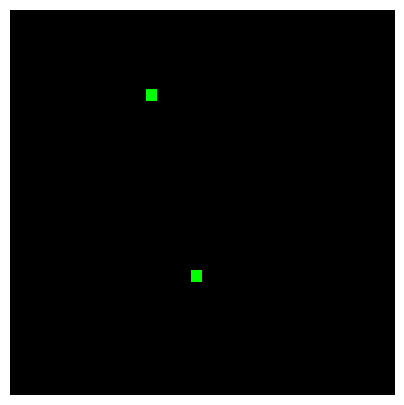

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for 

In [71]:
# Animation für verschiedene Samples
def show_sample_animation(sample_idx):
    """
    Zeigt die Animation für ein bestimmtes Sample
    """
    events, label = dataset[sample_idx]
    frames = trans(events)
    
    print(f"Sample {sample_idx}: Digit {label}")
    print(f"Frames shape: {frames.shape}")
    
    # Animation erstellen
    ani = tonic.utils.plot_animation(frames)
    return HTML(ani.to_jshtml())

# Animation für Sample 9 (wie im ursprünglichen Code)
print("🎬 Animation für Sample 9:")
display(show_sample_animation(9))


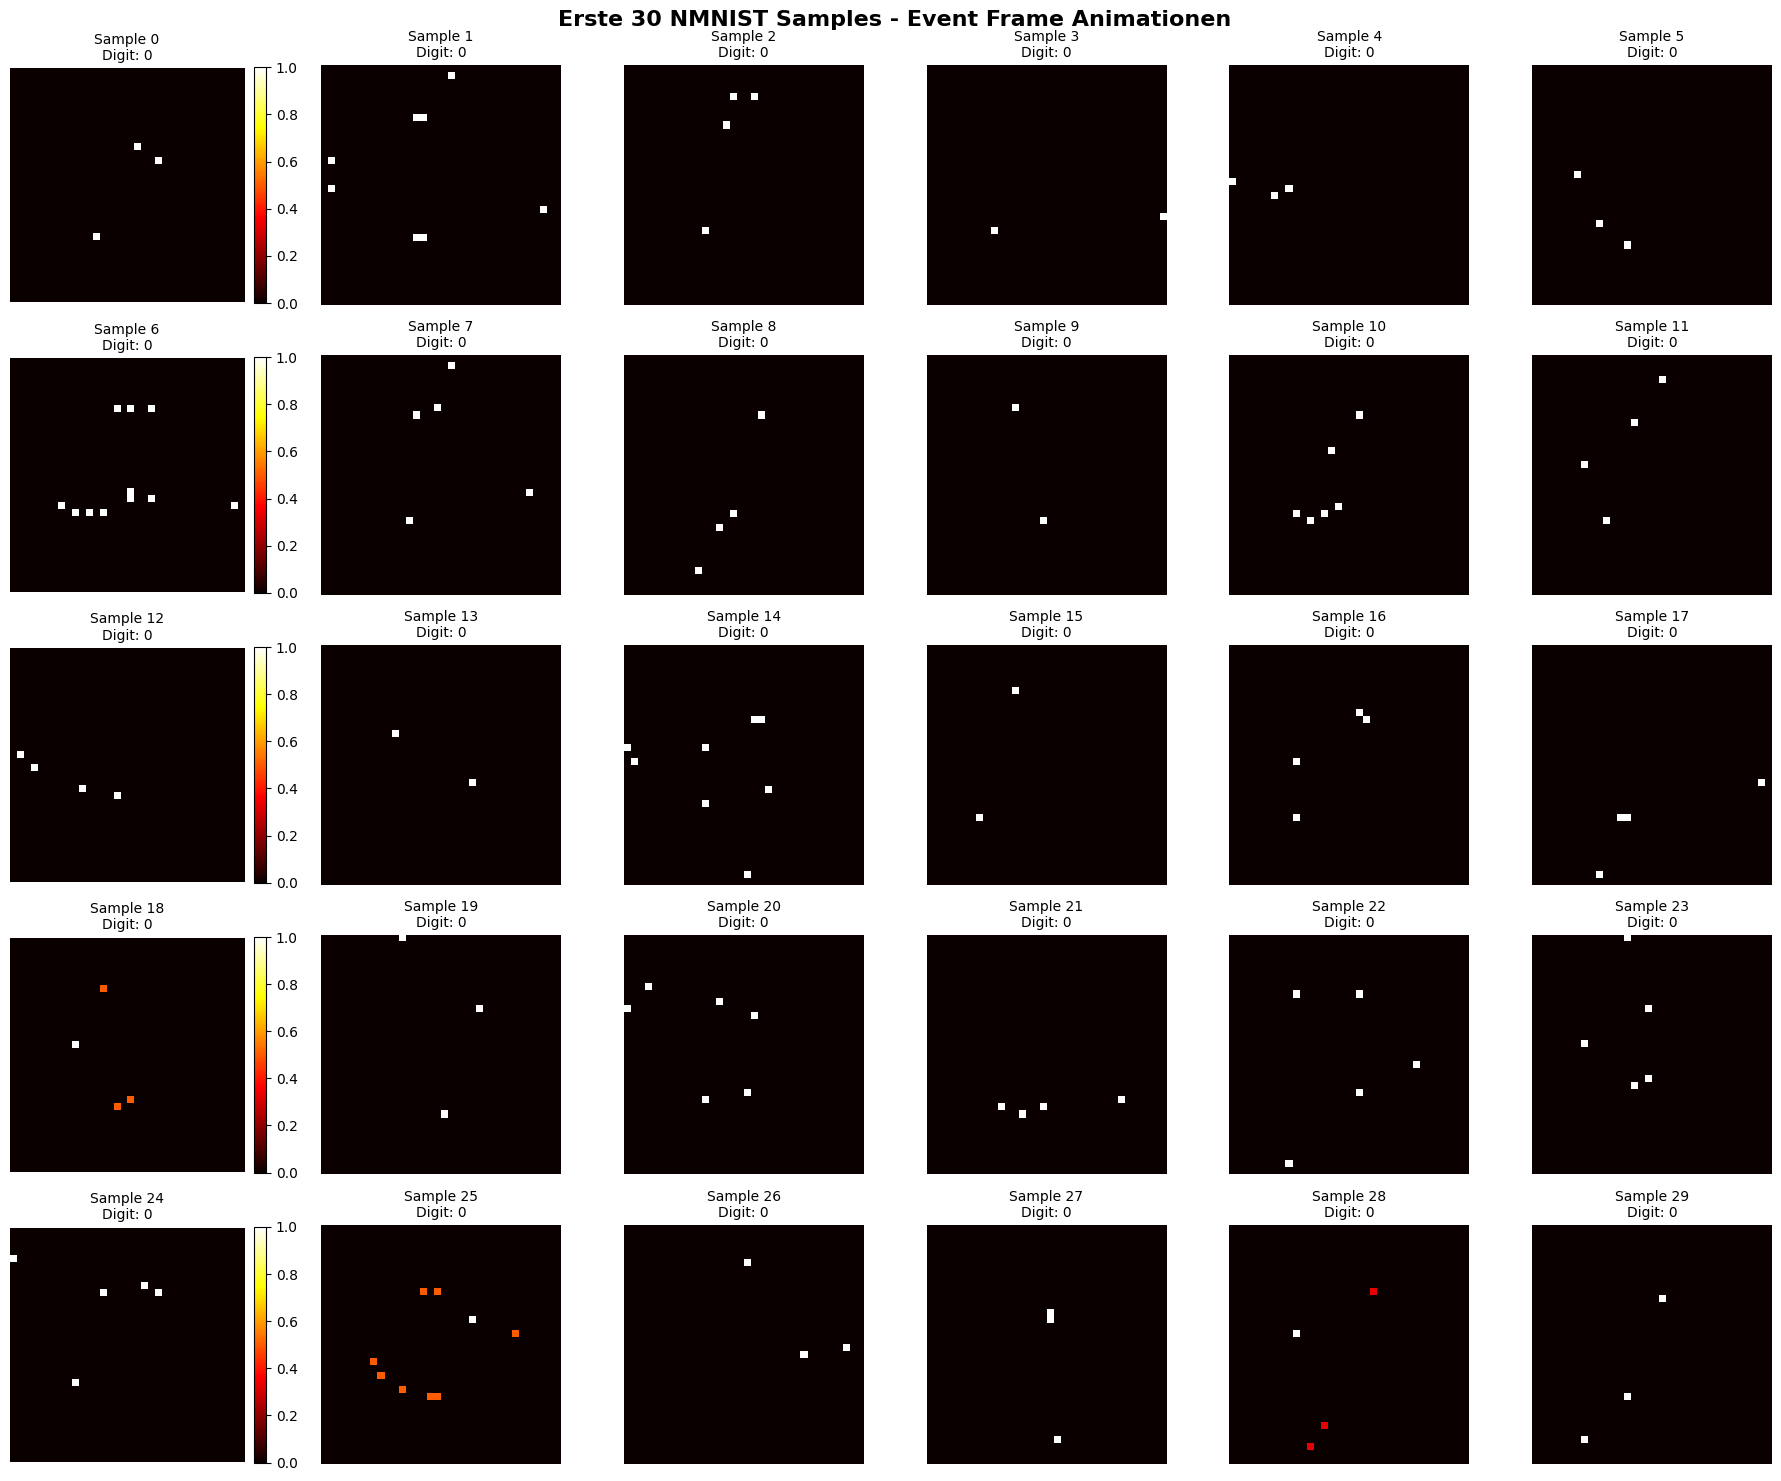

✅ 30 Animationen gezeigt!
🔥 Jedes Bild zeigt die erste Frame (Zeitbin 0) des jeweiligen Samples
🌈 Farben: Rot = viele Events, Schwarz = keine Events


In [72]:
# Plot der ersten 30 Animationen
def plot_first_30_animations():
    """
    Erstellt ein Grid mit den ersten 30 Animationen
    """
    n_samples = 30
    n_cols = 6  # 6 Spalten
    n_rows = 5  # 5 Zeilen
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 15))
    fig.suptitle('Erste 30 NMNIST Samples - Event Frame Animationen', fontsize=16, fontweight='bold')
    
    for i in range(n_samples):
        row = i // n_cols
        col = i % n_cols
        
        # Events und Label für Sample i
        events, label = dataset[i]
        frames = trans(events)
        
        # Erste Frame (Zeitbin 0) als Beispiel
        first_frame = frames[0]  # (2, 17, 17) - 2 Kanäle
        
        # Kombiniere beide Kanäle für bessere Visualisierung
        combined_frame = first_frame[0] + first_frame[1]  # ON + OFF Events
        
        # Normalisiere auf [0,1] um Clipping zu vermeiden
        if combined_frame.max() > 0:
            normalized_frame = combined_frame / combined_frame.max()
        else:
            normalized_frame = combined_frame
        
        # Plot
        im = axes[row, col].imshow(normalized_frame, cmap='hot', interpolation='nearest', vmin=0, vmax=1)
        axes[row, col].set_title(f'Sample {i}\nDigit: {label}', fontsize=10)
        axes[row, col].axis('off')
        
        # Farbbalken nur für die erste Spalte
        if col == 0:
            plt.colorbar(im, ax=axes[row, col], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()
    
    print(f"✅ {n_samples} Animationen gezeigt!")
    print("🔥 Jedes Bild zeigt die erste Frame (Zeitbin 0) des jeweiligen Samples")
    print("🌈 Farben: Rot = viele Events, Schwarz = keine Events")

# Erste 30 Animationen plotten
plot_first_30_animations()
